In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Input, Dense, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import warnings
warnings.filterwarnings('ignore')

## Main driver functions

In [2]:
def runif():
    return tf.random.uniform([1], dtype=tf.float32)[0]
    # return tf.constant(.8, tf.float32)

def rexp():
    return -tf.math.log(runif())

def reloid(x):
  '(sigma(x[1]), ..., sigma(x[-2]), relu(x[-1])'
  return tf.concat([
    tf.nn.sigmoid(x[:-1]),
    tf.nn.relu(x[-1:])
  ], axis=0)

# @tf.function
def R(x, theta):
  '''
  x: scalar
  theta: (3, H)
  '''
  # convert to vectors
  w = tf.expand_dims(theta,-1)[0]
  v = tf.expand_dims(theta,-1)[1]
  b = tf.expand_dims(theta,-1)[-1] 

  exp_w_v = tf.math.exp([w, v])
  ew = exp_w_v[0]
  ev = exp_w_v[1]

  x = tf.reshape(x, (1, 1))
  v0 = tf.transpose(ev) @ reloid(b)
  return tf.transpose(ev) @ reloid(ew @ x + b) - v0

# @tf.function
def Rinv(y, theta):
  x_left = 0
  w = tf.expand_dims(theta,-1)[0]
  v = tf.expand_dims(theta,-1)[1]
  b = tf.expand_dims(theta,-1)[-1]   
  # as x -> oo, R is asymyptotic to exp(v[-1] + w[-1]) x
  # fixme: calculate this exactly.
  x_right = 10 * y
  tf.debugging.assert_greater(R(x_right, theta), y)
  for i in range(50):
    x_i = (x_left + x_right) / 2.
    y_i = R(x_i, theta)
    left = tf.cast(y_i < y, dtype=float)
    x_left = left * x_i + (1. - left) * x_left
    x_right = (1. - left) * x_i + left * x_right
  return x_i

@tf.custom_gradient
def custom_Rinv(y, theta):
  x = Rinv(y, theta)
  with tf.GradientTape() as g:
    g.watch([x, theta])
    y = R(x, theta)
  dR_dtheta, dR_dx = g.gradient(y, [theta, x])
  def grad(dx):
    return dx / dR_dx, -dx * dR_dtheta / dR_dx
  return x, grad

# custom_Rinv(tf.constant(5.), theta)

# @tf.function
def gen_gaps(theta_vector, k: int,  
             theta=tf.constant(1e-4, dtype=tf.float32), 
             rho=tf.constant(1e-5, dtype=tf.float32)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    # w, v, b = tf.expand_dims(theta_vector,-1) # convert to vectors
    w = tf.expand_dims(theta_vector,-1)[0]
    v = tf.expand_dims(theta_vector,-1)[1]
    b = tf.expand_dims(theta_vector,-1)[-1] 

    z = tf.convert_to_tensor([[rexp()]])
    x = custom_Rinv(z, theta_vector)[0]  # initialize x by sampling from prior
    tf.debugging.assert_all_finite(x, 'first x')
    tf.debugging.assert_positive(x, message='gen_gaps first x')

    pos = tf.constant([0.], dtype=tf.float32)
    j = 0
    ta = tf.TensorArray(tf.float32, size=k + 2)

    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor([[u * x]])
        r_u_x = R(u_x,theta_vector) # compute R(u_x)
        x = custom_Rinv((z + r_u_x), theta_vector)[0]  # segment height
        # tf.print(z+r_u_x,"\n")
        tf.debugging.assert_all_finite(x,'second x')
        with tf.control_dependencies(
            [tf.debugging.assert_positive(x, message='gen_gaps second x')]
        ):
          pos += rexp() / (x * (theta + rho))  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            pos += rexp() / (x * (theta + rho))  # length to next event

    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    diff = ret[1:] - ret[:-1]
    with tf.control_dependencies([
        tf.debugging.assert_positive(diff, message='gen_gaps diff')
    ]):
      return tf.cast(diff, tf.float64)
      # return w[0]

## real R

In [3]:
# theta_real = tf.convert_to_tensor(np.random.normal(size=(3, 3)).astype(np.float32))
theta_real = tf.constant([[[ 0.14854327, -0.98326325, -0.43253738],
        [ 1.9020908 , -1.6436057 , -0.38470152],
        [ 0.4468235 ,  0.03053948,  2.0029104 ]]],shape=(3,3),dtype='float')
gen_gaps(theta_real,10)

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[3156.13671875],
       [5687.22460938],
       [4144.50195312],
       [1371.20898438],
       [ 802.37695312],
       [6197.82617188],
       [2354.671875  ],
       [ 231.25585938],
       [5939.20507812],
       [ 879.1640625 ]])>

In [4]:
w,v,b = tf.expand_dims(theta_real,-1)
w,v,b

(<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[ 0.14854327],
        [-0.98326325],
        [-0.43253738]], dtype=float32)>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[ 1.9020908 ],
        [-1.6436057 ],
        [-0.38470152]], dtype=float32)>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.4468235 ],
        [0.03053948],
        [2.0029104 ]], dtype=float32)>)

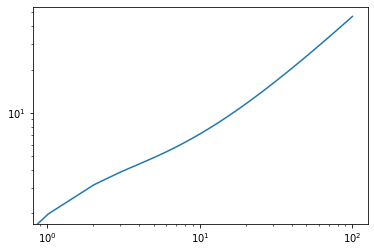

In [5]:
x = np.array([tf.constant(i,dtype=float) for i in np.linspace(0, 100, num=100)])
y = [R(i,theta_real) for i in x]
plt.yscale('log')
plt.xscale('log')
plt.plot(x.reshape(-1),tf.reshape(y,[-1]))

## Generator


In [6]:
warnings.filterwarnings('ignore')
class CustomGenGaps(keras.layers.Layer):
  ''' Take one parameter H as input 
      Then construct one hidden layer with H units'''
  def __init__(self, H, name='gen_gaps_layer'):
      super(CustomGenGaps, self,).__init__(name=name)
      init = tf.random_normal_initializer()
      self.theta = self.add_weight(shape=(3,H), initializer=init, dtype='float32',
                               trainable=True,
                              #  constraint=tf.keras.constraints.NonNeg(),
                              #  regularizer=tf.keras.regularizers.l1_l2(0.2,0.2)
                              )

  def call(self,length):
      return tf.reshape(gen_gaps(self.theta,length),[1,length])

class Generator(keras.Model):
  ''' wrap the GenGaps layer into Keras Model '''
  def __init__(self, H):
    super(Generator, self).__init__()
    self.GenLayer = CustomGenGaps(H)

  def call(self, inputs, training=True):
    return self.GenLayer(inputs)

H = 10
generator = Generator(H)
generator(10)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[ 2268.92578125,  8368.28320312,   412.5625    ,  4317.8515625 ,
        23118.7265625 , 65805.3125    ,  2865.75      ,   532.453125  ,
        18606.421875  ,  3718.578125  ]])>

In [7]:
generator.get_weights()[0][...,None]

array([[[ 0.11927787],
        [ 0.02330874],
        [-0.06950747],
        [-0.09219474],
        [ 0.00190649],
        [ 0.09206565],
        [-0.03190549],
        [-0.0167445 ],
        [-0.01333387],
        [-0.02597409]],

       [[-0.0103215 ],
        [-0.08382865],
        [ 0.03834145],
        [ 0.0809844 ],
        [ 0.03970837],
        [-0.01444318],
        [ 0.08534288],
        [-0.01284103],
        [-0.00962204],
        [ 0.0141372 ]],

       [[ 0.02373468],
        [-0.01119627],
        [-0.05946311],
        [ 0.03635522],
        [-0.02224464],
        [ 0.01233628],
        [-0.00725698],
        [ 0.02128925],
        [ 0.0549936 ],
        [-0.03357219]]], dtype=float32)

In [8]:
def SSE(x):
  r_hat = R(x,generator.weights[0])
  r = R(x,theta_real)
  return tf.math.sqrt(tf.math.square(r_hat - r)) * tf.math.exp(-x)

SSE(0.), SSE(1.)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.40699184]], dtype=float32)>)

Objective funtion

In [9]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_gaps_layer (CustomGenGap multiple                  30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Since activation of last layer of discriminator is None, I set from_logits to be True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

## Comparison between real and fake $R(x)$

In [11]:
theta_real, generator.weights

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[ 0.14854327, -0.98326325, -0.43253738],
        [ 1.9020908 , -1.6436057 , -0.38470152],
        [ 0.4468235 ,  0.03053948,  2.0029104 ]], dtype=float32)>,
 [<tf.Variable 'Variable:0' shape=(3, 10) dtype=float32, numpy=
  array([[ 0.11927787,  0.02330874, -0.06950747, -0.09219474,  0.00190649,
           0.09206565, -0.03190549, -0.0167445 , -0.01333387, -0.02597409],
         [-0.0103215 , -0.08382865,  0.03834145,  0.0809844 ,  0.03970837,
          -0.01444318,  0.08534288, -0.01284103, -0.00962204,  0.0141372 ],
         [ 0.02373468, -0.01119627, -0.05946311,  0.03635522, -0.02224464,
           0.01233628, -0.00725698,  0.02128925,  0.0549936 , -0.03357219]],
        dtype=float32)>])

weighted L2 norm: 1.0610595171654749


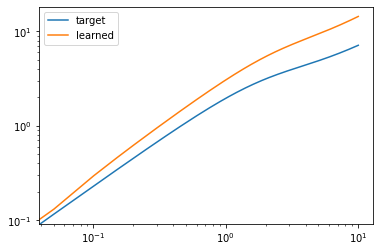

In [12]:
def performance_check(generator):
  # Real Generator Plot
  x = np.array([tf.constant(i,dtype=float) for i in np.linspace(0, 10, num=200)])
  y = [R(i,theta_real) for i in x]
  plt.plot(x.reshape(-1),tf.reshape(y,[-1]), label='target')
  # Plot fake R
  y = [R(i,generator.weights[0]) for i in x]
  plt.plot(x.reshape(-1),tf.reshape(y,[-1]), label='learned')
  plt.yscale('log')
  plt.xscale('log')
  print('weighted L2 norm:',integrate.quad(SSE, 0, np.inf)[0])
  plt.legend()
  plt.show()
performance_check(generator)

In [13]:
R(0.,generator.weights[0]), R(0., theta_real)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>)

## discriminator

In [14]:
discriminator = keras.Sequential(
    [
     Input(shape=(10,)),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(1)
    ],
    name="discriminator",
)


objective function

In [15]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.8):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [16]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2,
    decay_rate=0.96,
    staircase=True)
generator_optimizer = tf.keras.optimizers.RMSprop(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

## Define trining_step

In [17]:
@tf.function
def training_step(generator, discriminator, k):
    warnings.filterwarnings('ignore')
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            g_z = tf.math.log(generator(10)) / 10
            d_x_true = discriminator(tf.math.log(tf.reshape(gen_gaps(theta_real,10), (1,10))) / 10)
            d_x_fake = discriminator(g_z)

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # d_loss.append(discriminator_loss)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
            # tf.print('gradients_of_discriminator',gradients_of_discriminator)
              
            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            # tf.print('generator weights',generator.trainable_variables)
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

            # tf.print('gradients_of_generator',gradients_of_generator)
            # weight_list = tf.concat([tf.reshape(generator.weights[0],[-1]), 
                        #  tf.reshape(generator.weights[1],[-1]), 
                        #  tf.reshape(generator.weights[2],[-1])],axis=0)
            # theoretical, numerical=tf.test.compute_gradient(f,[weight_list])
            # tf.print(theoretical, numerical)
            # print()

In [18]:
def training(epoches):
  warnings.filterwarnings('ignore')
  for epoch in range(epoches):
    training_step(generator, discriminator ,10)
    mse.append(integrate.quad(SSE, 0, np.inf)[0])
    if (epoch % 50) == 0: 
      print('epoch', epoch)
      performance_check(generator)
      # plt.plot(range(len(d_loss)),d_loss)

epoch 0
weighted L2 norm: 0.7459659806101927


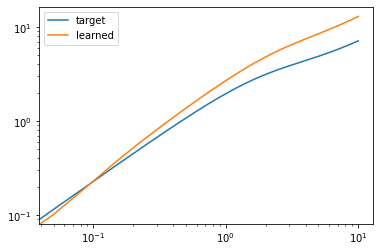

epoch 50
weighted L2 norm: 0.505195118203701


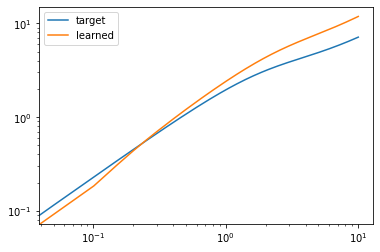

epoch 100
weighted L2 norm: 0.3150100480043343


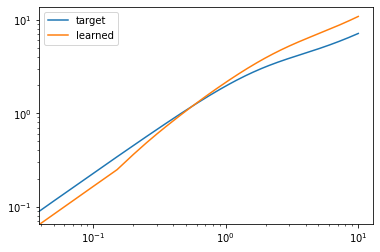

epoch 150
weighted L2 norm: 0.21832474716382086


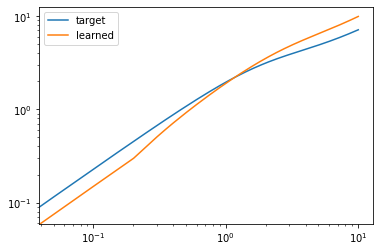

epoch 200
weighted L2 norm: 0.23039646565318564


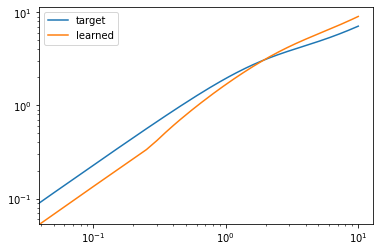

epoch 250
weighted L2 norm: 0.3191465451408592


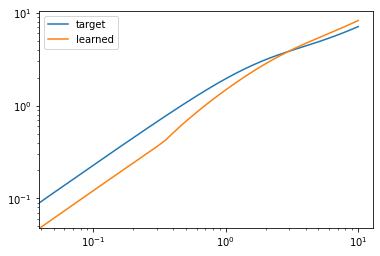

epoch 300
weighted L2 norm: 0.4456337425341658


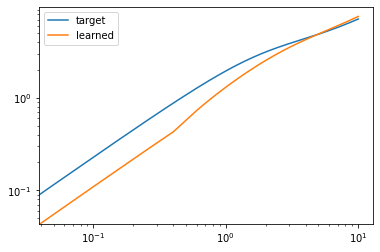

epoch 350
weighted L2 norm: 0.5781468723633492


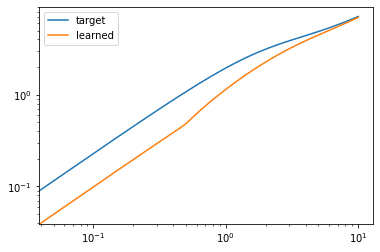

epoch 400
weighted L2 norm: 0.6860875458054992


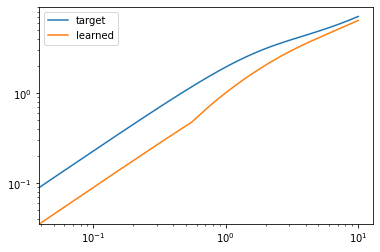

epoch 450
weighted L2 norm: 0.6361490999355432


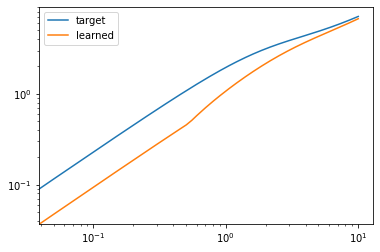

epoch 500
weighted L2 norm: 0.5113506681690254


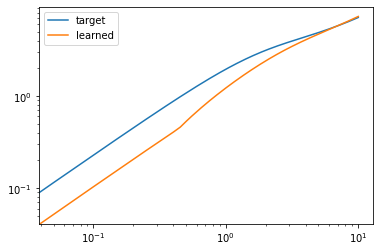

epoch 550
weighted L2 norm: 0.3810646654803115


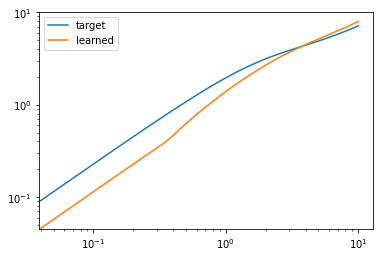

epoch 600
weighted L2 norm: 0.2684465473775204


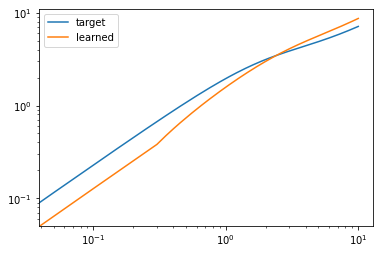

epoch 650
weighted L2 norm: 0.21224685975769955


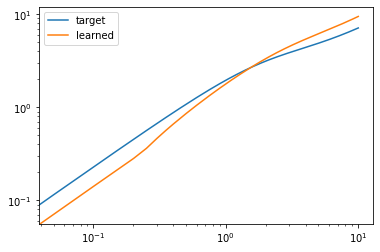

epoch 700
weighted L2 norm: 0.25039263994781785


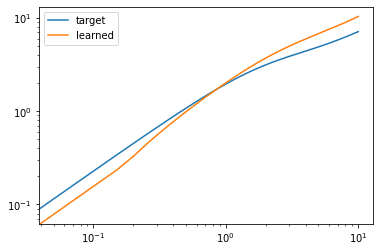

epoch 750
weighted L2 norm: 0.39636965194354895


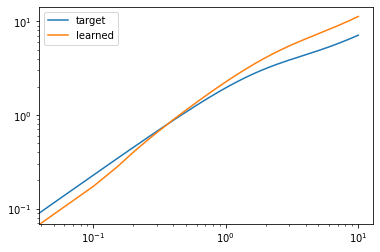

epoch 800
weighted L2 norm: 0.6060039137038966


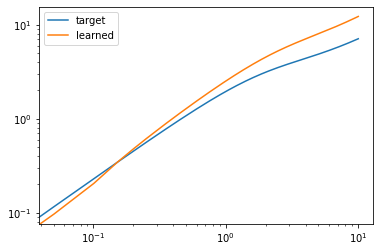

epoch 850
weighted L2 norm: 0.5660466579695329


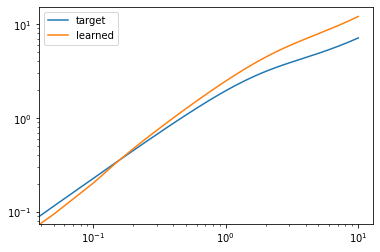

epoch 900
weighted L2 norm: 0.3671033715120131


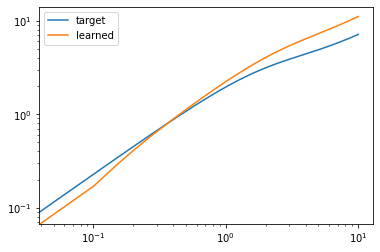

epoch 950
weighted L2 norm: 0.2294637724026511


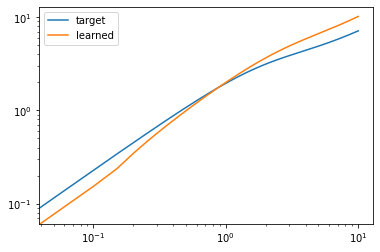

CPU times: user 1h 3min 20s, sys: 45.5 s, total: 1h 4min 6s
Wall time: 1h 3min 1s


In [20]:
%%time
mse = []
EPOCHES = 1000
training(EPOCHES)

Text(0.5, 1.0, 'minimum weighted l2 norm is at epoch: 990 and has value 0.195949')

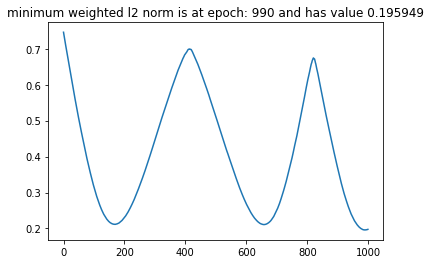

In [21]:
plt.plot(range(len(mse)),mse)
min_mse = min(mse)
min_pos = mse.index(min_mse)
plt.title(f"minimum weighted l2 norm is at epoch: {min_pos} and has value {min_mse:.6f}")